In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import r2_score, mean_squared_error, roc_auc_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("Card and Krueger.csv")
df = df.apply(pd.to_numeric, errors='coerce')

In [3]:
df

,sheet,chain,co_owned,state,southj,centralj,northj,pa1,pa2,shore,...,firstin2,special2,meals2,open2r,hrsopen2,psoda2,pfry2,pentree2,nregs2,nregs112
0,46,1,0,0,0,0,0,1,0,0,...,0.08,1.0,2.0,6.5,16.5,1.03,NaN,0.94,4.0,4.0
1,49,2,0,0,0,0,0,1,0,0,...,0.05,0.0,2.0,10.0,13.0,1.01,0.89,2.35,4.0,4.0
2,506,2,1,0,0,0,0,1,0,0,...,0.25,NaN,1.0,11.0,11.0,0.95,0.74,2.33,4.0,3.0
3,56,4,1,0,0,0,0,1,0,0,...,0.15,0.0,2.0,10.0,12.0,0.92,0.79,0.87,2.0,2.0
4,61,4,1,0,0,0,0,1,0,0,...,0.15,0.0,2.0,10.0,12.0,1.01,0.84,0.95,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405,423,2,1,1,0,0,1,0,0,0,...,0.50,0.0,1.0,11.0,11.0,1.05,0.84,2.32,3.0,2.0
406,424,2,1,1,0,0,1,0,0,0,...,0.50,0.0,1.0,11.0,14.0,1.05,0.94,2.32,5.0,3.0
407,426,3,1,1,0,0,1,0,0,0,...,0.25,1.0,2.0,6.0,18.0,1.11,1.05,1.05,6.0,5.0
408,427,4,0,1,0,0,1,0,0,0,...,NaN,1.0,2.0,10.5,12.5,1.11,1.09,2.07,2.0,2.0


In [4]:
df['pre_fte'] = df['empft'] + df['nmgrs'] + (0.5 * df['emppt'])
df['post_fte'] = df['empft2'] + df['nmgrs2'] + (0.5 * df['emppt2'])
df['delta_fte'] = df['post_fte'] - df['pre_fte']
df['gap'] = np.where((df['state'] == 1) & (df['wage_st'] < 5.05), (5.05 - df['wage_st']) / df['wage_st'], 0)
df['chain1'] = np.where(df['chain'] == 1, 1, 0)
df['chain2'] = np.where(df['chain'] == 2, 1, 0)
df['chain3'] = np.where(df['chain'] == 3, 1, 0)
df['chain4'] = np.where(df['chain'] == 4, 1, 0)

In [5]:
df.describe()

,sheet,chain,co_owned,state,southj,centralj,northj,pa1,pa2,shore,...,nregs2,nregs112,pre_fte,post_fte,delta_fte,gap,chain1,chain2,chain3,chain4
count,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,...,388.000000,383.000000,398.000000,396.000000,384.000000,410.000000,410.000000,410.000000,410.000000,410.000000
mean,246.507317,2.117073,0.343902,0.807317,0.226829,0.153659,0.426829,0.087805,0.104878,0.085366,...,3.608247,2.660574,20.973744,21.054293,-0.044401,0.080359,0.417073,0.195122,0.241463,0.146341
std,148.231799,1.110497,0.475589,0.394888,0.419293,0.361062,0.495221,0.283357,0.306771,0.279767,...,1.243540,0.886009,9.723900,9.094453,9.022491,0.076814,0.493678,0.396779,0.428493,0.353880
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,5.000000,0.000000,-41.500000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,119.250000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,3.000000,2.000000,14.562500,14.500000,-3.625000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,237.500000,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,3.000000,3.000000,19.500000,20.500000,0.000000,0.063158,0.000000,0.000000,0.000000,0.000000
75%,371.750000,3.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,4.000000,3.000000,24.500000,26.500000,4.000000,0.160920,1.000000,0.000000,0.000000,0.000000
max,522.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,8.000000,7.000000,85.000000,60.500000,34.000000,0.188235,1.000000,1.000000,1.000000,1.000000


In [6]:
df.isna().sum()

sheet          0
chain          0
co_owned       0
state          0
southj         0
centralj       0
northj         0
pa1            0
pa2            0
shore          0
ncalls         0
empft          6
emppt          4
nmgrs          6
wage_st       20
inctime       31
firstinc      43
bonus          0
pctaff        44
meals          0
open           0
hrsopen        0
psoda          8
pfry          17
pentree       12
nregs          6
nregs11       12
type2          0
status2        0
date2          0
ncalls2      249
empft2        12
emppt2        10
nmgrs2         6
wage_st2      21
inctime2      66
firstin2      80
special2      18
meals2        11
open2r        11
hrsopen2      11
psoda2        22
pfry2         28
pentree2      24
nregs2        22
nregs112      27
pre_fte       12
post_fte      14
delta_fte     26
gap            0
chain1         0
chain2         0
chain3         0
chain4         0
dtype: int64

In [7]:
df_clean = df.dropna(subset=['delta_fte', 'co_owned', 'chain2', 'chain3', 'chain4', 'inctime', 'firstinc', 'bonus', 'pctaff', 'meals', 'open', 'hrsopen', 'psoda', 'pfry', 'pentree', 'inctime2', 'firstin2', 'special2', 'meals2', 'open2r', 'hrsopen2', 'psoda2', 'pfry2', 'pentree2'])
# do we need imputation?

In [8]:
# Covariates for the DMLDiD procedure
X = df_clean[['co_owned', 'chain2', 'chain3', 'chain4',
              'inctime', 'firstinc', 'bonus', 'pctaff', 'meals', 'open', 'hrsopen', 'psoda', 'pfry', 'pentree', 
              'inctime2', 'firstin2', 'special2', 'meals2', 'open2r', 'hrsopen2', 'psoda2', 'pfry2', 'pentree2']].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# The outcome variable (delta employment change)
Y = df_clean['delta_fte'].values

# Treatment variable (1 in NJ, 0 in PA)
D = df_clean['state'].values

In [9]:
print(X.shape)
print(Y.shape)
print(D.shape)

(227, 23)
(227,)
(227,)


In [10]:
class neural_net(nn.Module):
    def __init__(self, input_size):
        super(neural_net, self).__init__()
        self.fc1 = nn.Linear(input_size, 10)
        self.fc2 = nn.Linear(10, 1)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
class neural_net_sigmoid(nn.Module):
    def __init__(self, input_size):
        super(neural_net_sigmoid, self).__init__()
        self.fc1 = nn.Linear(input_size, 10)
        self.fc2 = nn.Linear(10, 1)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x

In [11]:
# Hyperparameters
num_epochs = 100
learning_rate = 0.001
K = 5  # Number of folds

In [12]:
# Store intermediate ATT estimates
theta_k = []
# store all scores
all_scores = []
ps_train_losses, ps_val_losses = [], []  # Track propensity score losses
outcome_train_losses, outcome_val_losses = [], []  # Track outcome losses

In [13]:
kf = KFold(n_splits=K, shuffle=True, random_state=42)

In [14]:
for train_index, val_index in kf.split(X_scaled):
    # Split the data into train and validation sets
    X_train, X_val = X[train_index], X[val_index]
    D_train, D_val = D[train_index], D[val_index]
    Y_train, Y_val = Y[train_index], Y[val_index]

    # Convert data to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    D_train_tensor = torch.tensor(D_train, dtype=torch.float32).unsqueeze(1)
    Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32).unsqueeze(1)
    
    # Step 1: Train the neural network for propensity score prediction
    ps_model = neural_net_sigmoid(X_train.shape[1])
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(ps_model.parameters(), lr=learning_rate)
    
    ps_train_loss, ps_val_loss = [], [] # Store losses for each epoch
    
    # Train the propensity score model
    for epoch in range(num_epochs):
        ps_model.train()
        optimizer.zero_grad()
        ps_output = ps_model(X_train_tensor)
        loss = criterion(ps_output, D_train_tensor)
        loss.backward()
        optimizer.step()
        
        # Store training loss
        ps_train_loss.append(loss.item())

        # Validation loss
        ps_model.eval()
        with torch.no_grad():
            val_output = ps_model(X_val_tensor)
            val_loss = criterion(val_output, torch.tensor(D_val, dtype=torch.float32).unsqueeze(1))
            ps_val_loss.append(val_loss.item())
        
    ps_train_losses.append(ps_train_loss)
    ps_val_losses.append(ps_val_loss)

    
    # Step 2: Train the neural network for outcome prediction
    outcome_model = neural_net(X_train.shape[1])
    criterion = nn.MSELoss()
    optimizer = optim.Adam(outcome_model.parameters(), lr=learning_rate)
    
    outcome_train_loss, outcome_val_loss = [], []  # Store losses for each epoch

    # Train the outcome model
    for epoch in range(num_epochs):
        outcome_model.train()
        optimizer.zero_grad()
        outcome_output = outcome_model(X_train_tensor)
        loss = criterion(outcome_output, Y_train_tensor)
        loss.backward()
        optimizer.step()
        
       # Store training loss
        outcome_train_loss.append(loss.item())

        # Validation loss
        outcome_model.eval()
        with torch.no_grad():
            val_output = outcome_model(X_val_tensor)
            val_loss = criterion(val_output, torch.tensor(Y_val, dtype=torch.float32).unsqueeze(1))
            outcome_val_loss.append(val_loss.item())

    outcome_train_losses.append(outcome_train_loss)
    outcome_val_losses.append(outcome_val_loss)
    
        
    # Predict propensity scores and outcomes
    with torch.no_grad():
        D_hat_val = torch.sigmoid(ps_model(X_val_tensor)).numpy()
        D_hat_val = np.clip(D_hat_val, 0.01, 0.99)
        Y_hat_val = outcome_model(X_val_tensor).numpy()
        
    # Step 3: Compute the score function for this fold
    P_D = np.mean(D_val)
    score = ((D_val - D_hat_val.flatten()) / (P_D * (1 - D_hat_val.flatten()))) * (Y_val - Y_hat_val.flatten())
    all_scores.extend(score.flatten())

    # Calculate the ATT for this fold
    theta_k_fold = np.mean(score)
    theta_k.append(theta_k_fold)

    
# Step 4: Compute the final causal effect estimate (ATT)
theta_hat = np.mean(theta_k)
print(f"Estimated ATT using DMLDiD: {theta_hat}")

Estimated ATT using DMLDiD: 2.355534059867698


In [15]:
variance_estimates = []
P_D_overall = np.mean(D)

for score_val in all_scores:
    G_1p = -theta_hat / P_D_overall
    squared_term = (score_val + G_1p * (score_val - P_D_overall)) ** 2
    variance_estimates.append(squared_term)

# Final variance estimation
sigma_hat_squared = np.mean(variance_estimates) / len(all_scores)  # Average over all K folds
sigma_hat = np.sqrt(sigma_hat_squared)           # Standard deviation


print(f"Estimated standard deviation for ATT: {sigma_hat}")
ci_lower = theta_hat - 1.96 * sigma_hat
ci_upper = theta_hat + 1.96 * sigma_hat
print(f"95% CI for ATT: [{ci_lower}, {ci_upper}]")

Estimated standard deviation for ATT: 2.612910225604007
95% CI for ATT: [-2.7657699823161552, 7.476838102051551]


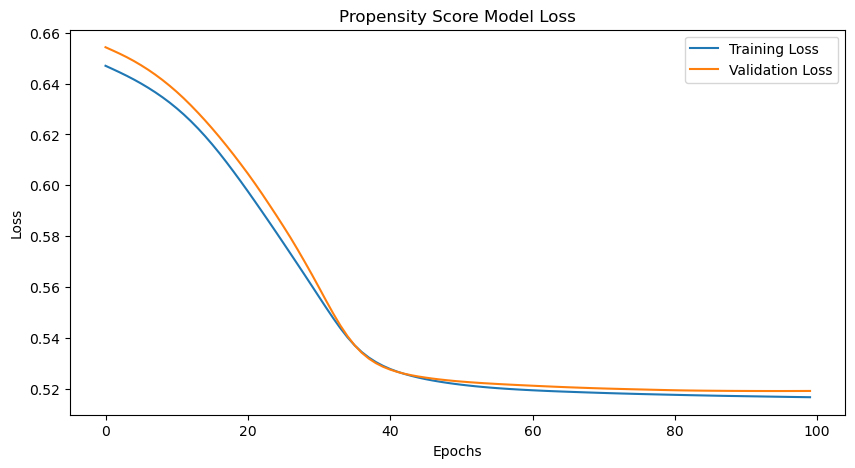

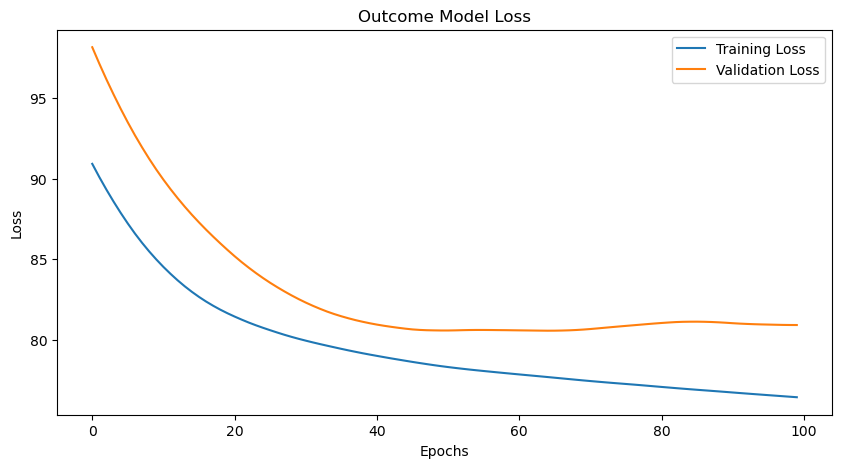

In [16]:
# Plotting Training and Validation Losses
def plot_loss(train_losses, val_losses, title):
    plt.figure(figsize=(10, 5))
    plt.plot(np.mean(train_losses, axis=0), label='Training Loss')
    plt.plot(np.mean(val_losses, axis=0), label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.show()

# Visualize losses
plot_loss(ps_train_losses, ps_val_losses, 'Propensity Score Model Loss')
plot_loss(outcome_train_losses, outcome_val_losses, 'Outcome Model Loss')